In [1]:
!pip install easydict
!pip install dgl

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
DataPath = "./Datasets/TerrorAttack/"

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import torch
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


print(os.listdir(DataPath))


from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        #fea1=[]
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
# Any results you write to the current directory are saved as output.

['.DS_Store', 'terrorist_attack_loc.edges', 'README', 'terrorist_attack.labels', 'terrorist_attack.nodes', 'terrorist_attack_loc_org.edges']


In [3]:
from __future__ import print_function
from __future__ import division

In [4]:
import torch.nn as nn
import torch.nn.functional as F
ListX1 = []
ListX2 = []

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                         dtype=np.int32)
    print(labels_onehot)
    return labels_onehot


class GCN(nn.Module):
    
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        
        print("Hidden Layers", nhid)
        self.gc1 = GraphConvolution(nfeat, nhid)
        
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout
 
    #fea2=[]
    #fea1=[]
    def forward(self, x, adj):
        x1 = self.gc1(x, adj)
        ListX1.append(x1)
        #print("X1 matrix - ", x1)
        
        fea1.append(x1)
        
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x2 = self.gc2(x, adj)
        ListX2.append(x2)
        #fea2.append(x2)
        
        x = self.gc2(x, adj)
        #fea2.append(x2)
        return F.log_softmax(x, dim=1)

In [5]:
import scipy.sparse as sp

def load_data(path=DataPath, dataset="TerrorAttack"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))
    
    idx_features_labels = np.genfromtxt(DataPath+"terrorist_attack.nodes",
                                        np.dtype(str),comments=None)
                                                                #.format(path, dataset)
                                                                #,dtype=None)
    #print(idx_features_labels)
    
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    #print(features)
    
    labels = encode_onehot(idx_features_labels[:, -1])
    #print(labels)
    
    #build graph
    idx = np.array(idx_features_labels[:, 0], dtype=None)
    #print("IDX = " , idx)
    idx_map = {j: i for i, j in enumerate(idx)}
    #print("IDX MAP = " , idx_map)
    
    edges_unordered = np.genfromtxt(DataPath+"terrorist_attack_loc.edges",
                                    np.dtype(str),comments=None)
    #print(edges_unordered)
    
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    #print("Edges", edges.size)
    
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    #print("Coo Matrix" ,adj)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    #print("Symmetric Adj matrix=" , adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))
    #print("Normalized Adj matrix=" , adj)
    
    idx_train = range(1200) #originally (180)
    idx_val = range(500, 1000) #originally (200,500)
    idx_test = range(1000, 1293) #originally (500,1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)
    #print("Sparce Adj matrix=" , adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    
    return adj, features, labels, idx_train, idx_val, idx_test

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

all_lab=[]
def accuracy(output, labels):
    all_lab.append(labels)
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [6]:
import numpy as np

adj, features, labels, idx_train, idx_val, idx_test  = load_data()
#print("train",features)
#print("labels",labels)


#print(adj)
#print(adj.size())
#print(adj.coalesce().indices().numpy()[0])
#print(adj.coalesce().indices().numpy()[1])
#print(adj.coalesce().values().numpy())
#print(adj.coalesce().values().numpy().size)

Loading TerrorAttack dataset...
[[0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 ...
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


In [7]:
import seaborn as sns
sns.heatmap(adj.to_dense().numpy(), cmap="YlGnBu") 

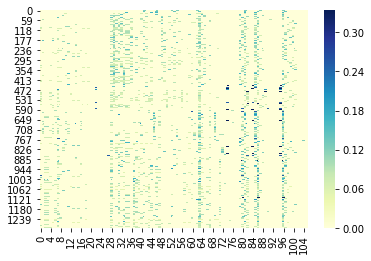

In [8]:
#print(features.cpu().numpy())
A = features.cpu().numpy()
sns.heatmap(A, cmap="YlGnBu")

In [ ]:
A = adj.to_dense().numpy()
X = features.cpu().numpy()
X0 = np.matmul(A,X)

sns.heatmap(X0, cmap="YlGnBu") 

In [ ]:
import csv
print(X0.shape)

#with open("./Heatmap dataset/Terr_X0.csv",'w') as resultFile:
#    wr = csv.writer(resultFile, dialect='excel')
#    wr.writerows(X0)


In [12]:
x = 0
y = 0
X0_list = [["group","variable","value"]]
for column in X0:
    for index in column:
        #print(y, x, X0[x][y])
        X0_list.append([y, x, X0[x][y]])
        y = y+1
    y = 0
    x = x+1
#print(X0_list)


#with open('./Heatmap dataset/W0_Matrix.csv', 'w') as writeFile:
#    writer = csv.writer(writeFile)
#    writer.writerows(X0_list)

#writeFile.close()

print("W0 written to CSV")

W0 written to CSV


In [13]:
from __future__ import division
from __future__ import print_function
import time
import argparse
import numpy as np
import easydict
import torch
import torch.nn.functional as F
import torch.optim as optim

#list_weights = []
# Training settings
# parser = argparse.ArgumentParser()
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='Disables CUDA training.')
# parser.add_argument('--fastmode', action='store_true', default=False,
#                     help='Validate during training pass.')
# parser.add_argument('--seed', type=int, default=42, help='Random seed.')
# parser.add_argument('--epochs', type=int, default=200,
#                     help='Number of epochs to train.')
# parser.add_argument('--lr', type=float, default=0.01,
#                     help='Initial learning rate.')
# parser.add_argument('--weight_decay', type=float, default=5e-4,
#                     help='Weight decay (L2 loss on parameters).')
# parser.add_argument('--hidden', type=int, default=16,
#                     help='Number of hidden units.')
# parser.add_argument('--dropout', type=float, default=0.5,
#                     help='Dropout rate (1 - keep probability).')

args = easydict.EasyDict({
        "no_cuda": False,
        "fastmode": False,
        "seed": 42,
        "epochs": 200,
        "lr": 0.01,
        "weight_decay": 5e-4,
        "hidden": 16, #hidden layer 
        "dropout": 0.5
})
args.cuda = not args.no_cuda and torch.cuda.is_available()
#print(args.no_cuda,torch.cuda.is_available(),args.cuda)
np.random.seed(args.seed)
#print(np.random.seed(args.seed))
#print(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=labels.max().item() + 1,
            dropout=args.dropout)

print("model is..d",model)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

all_logits = []
all_labels=[]
fea1=[]
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    print("log",output)
    all_logits.append(output.detach())
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    all_labels.append(labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    #print('Epoch: {:04d}'.format(epoch+1),
    #      'loss_train: {:.4f}'.format(loss_train.item()),
    #      'acc_train: {:.4f}'.format(acc_train.item()),
    #      'loss_val: {:.4f}'.format(loss_val.item()),
    #      'acc_val: {:.4f}'.format(acc_val.item()),
    #      'time: {:.4f}s'.format(time.time() - t))

print(all_logits)
print("Eval is -", model.eval())
print("feature size are",features.size())
#print("features are",features)
print("Model is -", model(features, adj).size())
print("Model Test is -", model(features, adj)[idx_test].size())

def test():
    model.eval()
    output = model(features, adj)
    #print("Output2 is -", output)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))


# Train model
t_total = time.time()


for epoch in range(args.epochs):
    train(epoch)
    #parameterlist = list(model.parameters())
    #w0 = parameterlist[0].detach().numpy()
    #list_weights.append(w0)
    #w1 = parameterlist[2].detach().numpy()
   
print("Model Parameters -", list(model.parameters()))
parameterlist = list(model.parameters())
#w0 = parameterlist[0].detach().numpy()
#w1 = parameterlist[2].detach().numpy()


print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))



import seaborn as sns

# Testing
test()

Loading TerrorAttack dataset...
[[0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 ...
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]
Hidden Layers 16
model is..d GCN(
  (gc1): GraphConvolution (106 -> 16)
  (gc2): GraphConvolution (16 -> 6)
)
[]
Eval is - GCN(
  (gc1): GraphConvolution (106 -> 16)
  (gc2): GraphConvolution (16 -> 6)
)
feature size are torch.Size([1293, 106])
Model is - torch.Size([1293, 6])
Model Test is - torch.Size([293, 6])
log tensor([[-1.4509, -2.1143, -1.6167, -1.9883, -2.2628, -1.5830],
        [-1.4623, -2.1473, -1.4945, -2.0461, -2.3021, -1.6202],
        [-1.5013, -2.1136, -1.6513, -1.9944, -2.1888, -1.5306],
        ...,
        [-1.5882, -2.1209, -1.5952, -1.9817, -2.2173, -1.4864],
        [-1.5970, -2.0852, -1.7259, -1.9012, -2.1580, -1.4685],
        [-1.5161, -1.9829, -1.7907, -2.0554, -2.0190, -1.5367]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-1.6019, -2.1790, -1.3935, -1.9927, -2.1716, -1.6777],
        [-1.6544, -2.1533, -1.4228, -2.0947, -2.26

log tensor([[-2.1171, -4.6993, -0.5768, -4.1054, -1.2563, -4.8747],
        [-1.1705, -4.2191, -0.7798, -2.8423, -2.0933, -3.3526],
        [-1.9085, -4.0728, -0.9512, -3.7975, -0.8937, -4.0846],
        ...,
        [-2.3842, -4.1699, -0.7743, -4.0237, -0.9274, -4.0226],
        [-1.9674, -4.5187, -1.1910, -3.7955, -0.6691, -4.5380],
        [-3.5101, -5.3616, -1.5763, -5.7768, -0.2824, -6.4415]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.3516, -3.9990, -0.5312, -3.6791, -1.3860, -3.7618],
        [-2.2460, -2.8115, -0.9397, -2.9432, -1.2978, -2.1413],
        [-1.9007, -4.1151, -0.9276, -3.7764, -0.9168, -4.1346],
        ...,
        [-2.1348, -4.0098, -0.7257, -3.8804, -1.0720, -4.0960],
        [-1.9892, -4.0609, -0.7999, -4.1221, -0.9915, -4.6718],
        [-2.9320, -3.4969, -0.7664, -4.2788, -0.8974, -3.4986]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.3962, -4.7956, -0.6331, -4.3704, -1.0478, -5.0561],
        [-1.3973, -4.8163, -0.6079, -3.8454, -1.7705, 

log tensor([[-2.0512, -3.9020, -0.7260, -3.3440, -1.1649, -3.9071],
        [-1.8052, -4.9030, -0.5166, -3.3956, -1.6672, -4.6756],
        [-1.8079, -4.1989, -1.1864, -3.5680, -0.7439, -4.4055],
        ...,
        [-2.7603, -4.5457, -0.6007, -3.8273, -1.0571, -4.7703],
        [-3.7034, -4.2248, -0.9410, -4.3807, -0.5956, -4.9933],
        [-4.2915, -3.5971, -0.8611, -4.1137, -0.6990, -3.7817]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.2592, -4.6287, -0.4155, -3.4162, -1.6999, -4.5778],
        [-4.4894, -6.5463, -0.0934, -5.1124, -2.6703, -6.7146],
        [-1.8088, -3.7855, -1.1341, -3.3969, -0.8264, -3.8817],
        ...,
        [-2.4530, -4.3262, -0.7261, -3.6782, -0.9655, -4.5173],
        [-4.6029, -4.9445, -1.0950, -5.1807, -0.4482, -5.5545],
        [-1.7420, -5.2401, -2.2931, -3.6434, -0.3744, -5.3568]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.0756, -4.0741, -0.6892, -3.5206, -1.1638, -4.2955],
        [-2.3253, -4.1330, -0.5153, -3.7835, -1.3997, 

log tensor([[-3.0708, -3.8896, -0.4737, -3.3276, -1.3658, -3.9415],
        [-1.7980, -3.7585, -0.5290, -3.0965, -2.0762, -2.9712],
        [-1.5410, -3.7118, -1.5755, -3.1583, -0.7046, -4.0335],
        ...,
        [-2.8022, -3.9155, -0.7975, -3.3880, -0.8606, -4.4042],
        [-1.3257, -2.9522, -1.7773, -2.7317, -0.9745, -2.6514],
        [-4.4751, -5.0385, -2.2874, -4.5402, -0.1428, -5.8150]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.5649, -4.0120, -0.4058, -3.1083, -1.7113, -4.3259],
        [-2.5268, -3.9306, -0.6845, -3.2919, -1.0713, -4.1115],
        [-1.8113, -3.6526, -1.4860, -3.2968, -0.6308, -4.1880],
        ...,
        [-2.5181, -4.0166, -0.8060, -3.3146, -0.9019, -4.3735],
        [-2.8130, -4.5643, -2.7156, -4.3137, -0.1701, -5.0436],
        [-3.6212, -5.0447, -2.3166, -4.6874, -0.1558, -5.7399]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.2715, -3.7894, -0.5404, -3.1088, -1.4888, -3.8435],
        [-3.6599, -4.0629, -0.1691, -3.0243, -3.4548, 

log tensor([[-2.5539, -4.0462, -0.3576, -3.1623, -1.9163, -4.1392],
        [-3.1896, -3.3276, -0.3082, -2.5841, -2.6911, -3.1028],
        [-1.4676, -3.6239, -1.6844, -3.2609, -0.6941, -3.9426],
        ...,
        [-2.8636, -3.7045, -0.6740, -3.1318, -1.0569, -4.0445],
        [-1.5000, -3.1471, -2.3437, -3.5297, -0.5602, -3.2826],
        [-5.9364, -6.9626, -4.7007, -7.1935, -0.0137, -8.7688]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.9961, -4.2224, -0.2558, -3.3742, -2.1745, -4.3293],
        [-3.6484, -5.3082, -0.0769, -3.5678, -4.8735, -4.9400],
        [-1.5037, -3.4738, -1.6127, -3.1354, -0.7284, -3.8539],
        ...,
        [-2.9430, -3.6630, -0.6546, -3.1395, -1.0813, -3.9363],
        [-2.1920, -2.4645, -1.4064, -2.6603, -0.9240, -2.3929],
        [-4.6359, -6.5404, -4.9246, -6.3513, -0.0206, -8.5316]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.1321, -3.5901, -0.5148, -2.8729, -1.7618, -3.5782],
        [-2.3256, -3.5291, -0.5295, -2.9414, -1.6133, 

log tensor([[-2.6949, -3.8515, -0.4618, -3.1049, -1.5261, -3.9717],
        [-1.7780, -2.9456, -0.8879, -2.6907, -1.5872, -2.3581],
        [-1.9381, -3.7216, -1.7011, -3.3605, -0.5115, -4.1953],
        ...,
        [-2.5741, -3.7916, -0.9611, -3.2845, -0.7582, -4.3604],
        [-4.0804, -5.3042, -2.5362, -5.0324, -0.1150, -6.7977],
        [-2.7557, -4.6480, -2.9303, -4.1414, -0.1578, -5.6519]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.3554, -3.4120, -0.6493, -2.8633, -1.3353, -3.5199],
        [-2.8572, -4.3178, -0.3101, -3.5013, -1.8875, -4.2514],
        [-1.8544, -3.8089, -1.7891, -3.4313, -0.4965, -4.3304],
        ...,
        [-3.0314, -3.8787, -0.7347, -3.2807, -0.9104, -4.4695],
        [-2.8142, -4.7198, -2.1763, -4.1909, -0.2243, -5.6699],
        [-3.8359, -4.7781, -3.0809, -5.4713, -0.0860, -6.0833]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-1.9332, -3.3994, -0.6382, -2.7540, -1.6096, -3.5054],
        [-0.7544, -4.0717, -0.9174, -3.1040, -3.0584, 

log tensor([[-2.7126, -3.7890, -0.3701, -2.9790, -1.9026, -3.8970],
        [-1.9154, -4.3763, -0.3550, -3.2578, -2.4208, -4.4531],
        [-1.0889, -3.7106, -2.1840, -3.3621, -0.7514, -3.9125],
        ...,
        [-2.8441, -3.4473, -0.7450, -2.9842, -1.0152, -3.8017],
        [-6.0923, -6.0688, -3.6848, -6.8052, -0.0315, -8.3594],
        [-2.4341, -5.4263, -3.7225, -5.3028, -0.1315, -6.2094]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.6118, -3.6230, -0.3620, -2.7601, -2.1520, -3.7262],
        [-2.1426, -4.7547, -0.2205, -3.0615, -4.0754, -4.8164],
        [-1.7096, -3.6915, -1.8502, -3.3609, -0.5346, -4.1179],
        ...,
        [-2.9424, -3.7373, -0.8058, -3.2425, -0.8596, -4.2448],
        [-4.4884, -4.0266, -1.8915, -4.2333, -0.2218, -5.4010],
        [-4.1429, -5.1391, -3.6827, -5.7107, -0.0524, -7.1301]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.6811, -3.5096, -0.4884, -2.8692, -1.5971, -3.5482],
        [-2.7442, -5.1549, -0.1321, -3.3784, -4.2515, 

log tensor([[-2.2406, -3.2881, -0.7547, -2.7606, -1.2630, -3.2167],
        [-3.1108, -4.8862, -0.1362, -3.2903, -3.4904, -4.8916],
        [-1.7629, -3.7516, -2.3307, -3.5331, -0.4075, -4.3263],
        ...,
        [-2.7259, -3.5521, -0.9446, -3.0321, -0.8009, -3.9185],
        [-4.0166, -3.2896, -1.3659, -3.8167, -0.4387, -3.7852],
        [-2.8067, -4.7719, -2.9935, -4.2862, -0.1453, -6.0039]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.5491, -3.7995, -0.4855, -2.9623, -1.5262, -4.1983],
        [-2.7747, -4.0696, -0.2493, -2.6642, -2.8639, -4.2343],
        [-1.5632, -3.5956, -2.2041, -3.4339, -0.5110, -3.8827],
        ...,
        [-3.2386, -3.9323, -1.0124, -3.4516, -0.6224, -4.6584],
        [-2.2853, -3.5616, -2.2299, -3.3306, -0.3543, -3.6938],
        [-4.8328, -4.9393, -2.7796, -5.4964, -0.0870, -6.1766]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.6047, -3.7325, -0.4685, -2.9748, -1.5826, -3.9269],
        [-1.7793, -3.0036, -0.9958, -2.6782, -1.2895, 

log tensor([[-2.5022, -3.6796, -0.3969, -2.7469, -2.0297, -3.6892],
        [-2.6046, -3.6338, -0.3472, -2.3528, -2.6496, -3.6056],
        [-1.7665, -3.3077, -1.7228, -3.2065, -0.6020, -3.6623],
        ...,
        [-2.6843, -3.6566, -0.8066, -3.1961, -0.9155, -4.0014],
        [-0.7746, -4.7733, -4.2831, -4.6836, -0.6882, -5.2725],
        [-4.2102, -3.6633, -1.3960, -4.0638, -0.3816, -4.4243]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.6231, -3.8637, -0.3312, -3.0599, -2.1220, -3.8323],
        [-2.2232, -3.6532, -0.4121, -2.6867, -2.3884, -3.1311],
        [-1.7409, -3.3598, -1.6364, -3.1216, -0.6420, -3.6938],
        ...,
        [-2.3551, -3.6384, -0.8853, -3.0260, -0.9191, -3.9712],
        [-5.0771, -5.1052, -2.4361, -4.9946, -0.1154, -6.0256],
        [-1.8342, -5.5540, -4.1608, -5.0475, -0.2067, -6.8210]],
       grad_fn=<LogSoftmaxBackward>)
log tensor([[-2.1686, -3.3456, -0.5977, -2.7372, -1.6325, -3.2151],
        [-2.9386, -4.3460, -0.1933, -3.1002, -3.2537, 

In [14]:
#print(ListX1[len(ListX1)-1].size())
#print(ListX1[len(ListX1)-1].detach().numpy())
X1 = ListX1[len(ListX1)-1].detach().numpy()

print("   ")
#print(ListX2[len(ListX2)-1].size())
#print(ListX2[len(ListX2)-1].detach().numpy())
X2 = ListX2[len(ListX2)-1].detach().numpy()

In [15]:
import csv

DF_X1_Epochs = pd.DataFrame()
DF_X1  = pd.DataFrame()
i = 0
while i <= 200: 
    X1 = ListX1[i].detach().numpy()
    DF_X1 = pd.DataFrame(X1)
    DF_X1["Epochs"] = i
    #DF_X1_Epochs.append(DF_X1)
    DF_X1_Epochs = pd.concat([DF_X1_Epochs,DF_X1])
    i = i + 10
print(DF_X1_Epochs)

#with open("Heatmap dataset/Terr_X1_Epochs.csv", 'w+') as f:
#    DF_X1_Epochs.to_csv(f, header=True)
    

             0         1         2         3         4         5         6  \
0     0.032897  0.118523 -0.055517 -0.105684 -0.173803  0.094558  0.216544   
1    -0.039621  0.104729 -0.033400 -0.122704 -0.180175  0.000484  0.202948   
2    -0.001135  0.056986 -0.046505 -0.107587 -0.221691  0.108646  0.252044   
3     0.024143  0.092012 -0.086266 -0.105039 -0.180707  0.100221  0.280124   
4     0.010824  0.108512 -0.026149 -0.090027 -0.208610  0.075398  0.231849   
5    -0.004252  0.060414 -0.005841 -0.040610 -0.189936  0.093040  0.250066   
6     0.002301  0.064418 -0.117877 -0.080151 -0.203484  0.091047  0.260006   
7     0.052040  0.072583 -0.022807 -0.109726 -0.201905  0.112298  0.282805   
8     0.014730  0.059988  0.056855 -0.012356 -0.228484  0.075512  0.212083   
9     0.062738  0.084892 -0.023290 -0.117191 -0.189528  0.070011  0.265804   
10    0.010824  0.108512 -0.026149 -0.090027 -0.208610  0.075398  0.231849   
11    0.025115  0.064052 -0.048044 -0.100250 -0.217098  0.100641

In [16]:
import csv

DF_X2_Epochs = pd.DataFrame()
DF_X2  = pd.DataFrame()
i = 0
while i <= 200: 
    X2 = ListX2[i].detach().numpy()
    DF_X2 = pd.DataFrame(X2)
    DF_X2["Epochs"] = i
    #DF_X1_Epochs.append(DF_X1)
    DF_X2_Epochs = pd.concat([DF_X2_Epochs,DF_X2])
    i = i + 10
print(DF_X2_Epochs)

#with open("Heatmap dataset/Terr_W2_Epochs.csv", 'w+') as f:
#    DF_X2_Epochs.to_csv(f, header=True)
    

             0         1         2         3         4         5  Epochs
0     0.278068 -0.332514  0.215964 -0.156420 -0.408615  0.240893       0
1     0.263675 -0.339663  0.242547 -0.183609 -0.425692  0.179241       0
2     0.270889 -0.271859  0.225856 -0.144052 -0.357711  0.310660       0
3     0.267989 -0.295527  0.213267 -0.133691 -0.390604  0.311974       0
4     0.272747 -0.299818  0.212036 -0.148824 -0.382062  0.261401       0
5     0.267840 -0.314114  0.220300 -0.142649 -0.383728  0.280569       0
6     0.257824 -0.288725  0.196281 -0.126364 -0.366202  0.291970       0
7     0.257887 -0.286962  0.242159 -0.140117 -0.378622  0.304565       0
8     0.228259 -0.279508  0.258377 -0.185331 -0.363534  0.232967       0
9     0.257204 -0.307539  0.230353 -0.156416 -0.390376  0.262949       0
10    0.272747 -0.299818  0.212036 -0.148824 -0.382062  0.261401       0
11    0.261645 -0.287666  0.246310 -0.141026 -0.361725  0.284613       0
12    0.273522 -0.306479  0.238458 -0.150051 -0.373

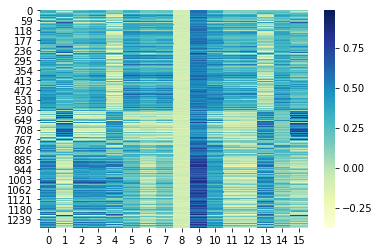

In [17]:
sns.heatmap(X1, cmap="YlGnBu")

In [18]:
len(fea1)

403

In [19]:
import csv
#with open("tsne_epochs.csv", 'w+') as f:
#    writer = csv.writer(f, delimiter=',')
#    writer.writerow(["NodeID","Group","Dim_1","Dim_2","Epochs"])

In [20]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
i = 0
while i<=200:
    output=fea1[i].detach().numpy()
    md=TSNE(n_components=2,random_state=0,perplexity = 30,learning_rate  = 100, n_iter=5000) #Define TSNE model
    tsne_data=md.fit_transform(output) #Apply TSNE on the 190 iter
    tsne_data=np.vstack((labels,tsne_data.T)).T #Stack 
    tsne_df=pd.DataFrame(data=tsne_data,columns=["label","Dim_1","Dim_2"])
    tsne_df["Epochs"] = i
    #print(tsne_df)
#    with open("tsne_epochs.csv", 'a+') as f:
#        tsne_df.to_csv(f, header=False)
    print("iteraction - ", i)
    i = i+10

iteraction -  0
iteraction -  10
iteraction -  20
iteraction -  30
iteraction -  40
iteraction -  50
iteraction -  60
iteraction -  70
iteraction -  80
iteraction -  90
iteraction -  100
iteraction -  110
iteraction -  120
iteraction -  130
iteraction -  140
iteraction -  150
iteraction -  160
iteraction -  170
iteraction -  180
iteraction -  190
iteraction -  200


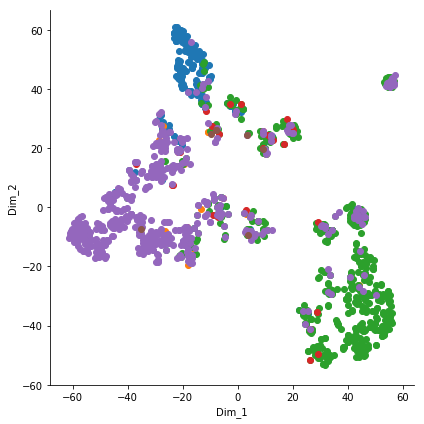

In [21]:
sns.FacetGrid(tsne_df,hue="label",height=6).map(plt.scatter,"Dim_1","Dim_2")
plt.show()

In [22]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
outp=fea1[10].detach().numpy()
data_1000=outp
labels_1000=labels
print(labels)
md=TSNE(n_components=2,random_state=0,perplexity = 30,learning_rate  = 100, n_iter=5000)

tsne_data=md.fit_transform(data_1000)

tsne_data=np.vstack((labels_1000,tsne_data.T)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=["label","Dim_1","Dim_2"])
#print(tsne_df)
#export_csv = tsne_df.to_csv ('files.csv', index = None, header=True)

tensor([3, 3, 3,  ..., 4, 4, 4])


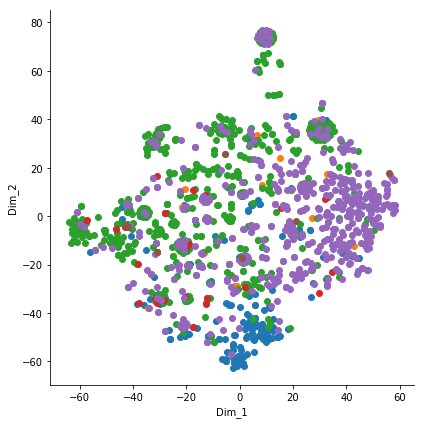

In [23]:
sns.FacetGrid(tsne_df,hue="label",height=6).map(plt.scatter,"Dim_1","Dim_2")
plt.show()

In [24]:
print(list_weights[1].shape)

NameError: name 'list_weights' is not defined

In [ ]:
import matplotlib.pyplot as plt

#fig,ax = plt.subplots(1,2)

#sns.heatmap(data = list_weights[1])
#sns.palplot(sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0))
sns.heatmap(list_weights[0], cmap="YlGnBu")
#sns.heatmap(data = list_weights[1],ax=[1,0])

In [ ]:
sns.heatmap(list_weights[1], cmap="YlGnBu")

In [ ]:
#print("0 = ", list_weights[0])
#print("1 = ", list_weights[1])

In [ ]:
sns.heatmap(w0)
#print(w0)

In [ ]:
#sns.heatmap(w1)

In [ ]:
import seaborn as sns
import numpy as np
print(features.cpu().numpy())
A = features.cpu().numpy()
sns.heatmap(A)

In [ ]:
import dgl
import networkx as nx

g = dgl.DGLGraph()
g.add_nodes(1293)
idx_features_labels = np.genfromtxt(DataPath+"terrorist_attack.nodes",
                                        np.dtype(str),comments=None)

features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
#print(features)

labels = encode_onehot(idx_features_labels[:, -1])
#print(labels)

#build graph
idx = np.array(idx_features_labels[:, 0], dtype=None)
#print(idx)
idx_map = {j: i for i, j in enumerate(idx)}

edges_unordered = np.genfromtxt(DataPath+"terrorist_attack_loc.edges",
                                np.dtype(str),comments=None);
edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),dtype=np.int32).reshape(edges_unordered.shape)
    
src, dst = tuple(zip(*edges));
g.add_edges(src, dst);
g.add_edges(dst, src);
print('We have %d nodes.' % g.number_of_nodes())
print('We have %d edges.' % g.number_of_edges())
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = g.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
#print("pos: ",pos)
#nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])
